In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import urllib.request, json, requests, base64
import sys
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
# Define API URL and SPK filename:

start_time = '2020-01-01'
stop_time = '2021-01-30'
earth = '399'
moon = '301'
ephem_type = 'VECTOR'
center = '500@3'
time_span = 'h'

In [3]:
# функция-парсер с сайта HORIZONS

def get_data_from_horizons(start_time, stop_time, body, ephem_type, center, time_span):
    url = 'https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=%27' + body + '%27&OBJ_DATA=%27NO%27&MAKE_EPHEM=%27YES%27&EPHEM_TYPE=%27VECTOR%27&CENTER=%27'  + center + '%27&START_TIME=%27' + start_time + '%27&STOP_TIME=%27' + stop_time + '%27&STEP_SIZE=%271%20' + time_span +'%27&QUANTITIES=%272%27'
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    output = soup.get_text()

    row_list = list()
    flag = False
    for row in output.splitlines():
        if row == '$$SOE':
            flag = True

        if row == '$$EOE':
            flag = False
        if flag:
            row_list.append(row)

    row_list = row_list[1:]
    body_data = pd.DataFrame()
    body_data['astro_date'], body_data['date_time'], body_data['x'], body_data['y'], body_data['z'] = [np.nan, np.nan, np.nan, np.nan, np.nan]
    j = 0
    while j < len(row_list):
        body_data.loc[j, 'astro_date'] = float(row_list[j][:row_list[j].find('=')])
        j = j + 4
    j = 0
    while j < len(row_list):
        body_data.loc[j, 'date_time'] = row_list[j][row_list[j].find('A.D.')+5:row_list[j].find('TDB ')-1]
        j = j + 4
    j = 1
    while j < len(row_list):
        body_data.loc[j-1, 'x'] = float(row_list[j][row_list[j].find('=')+1:row_list[j].find('Y')])
        j = j + 4
    j = 1
    while j < len(row_list):
        body_data.loc[j-1, 'y'] = float(row_list[j][row_list[j].find('Y =')+3:row_list[j].find('Z')])
        j = j + 4
    j = 1
    while j < len(row_list):
        body_data.loc[j-1, 'z'] = float(row_list[j][row_list[j].find('Z =')+3:])
        j = j + 4
    body_data.reset_index(drop=True)
    
    return body_data

In [4]:
# функция отрисовщик движения
def draw_planet_motion(body_data, end_point, colour, planet_size):
    if end_point == True:
        ax.plot3D(body_data['x'].values, body_data['y'].values, body_data['z'].values, color = colour)
        ax.scatter(body_data['x'].values[-1], body_data['y'].values[-1], body_data['z'].values[-1], color = colour, s = planet_size)
    if end_point == False:
        ax.plot3D(body_data['x'].values, body_data['y'].values, body_data['z'].values, color = colour)

In [5]:
earth_motion = get_data_from_horizons(start_time, stop_time, earth, ephem_type, center, time_span)
moon_motion = get_data_from_horizons(start_time, stop_time, moon, ephem_type, center, time_span)

<IPython.core.display.Javascript object>


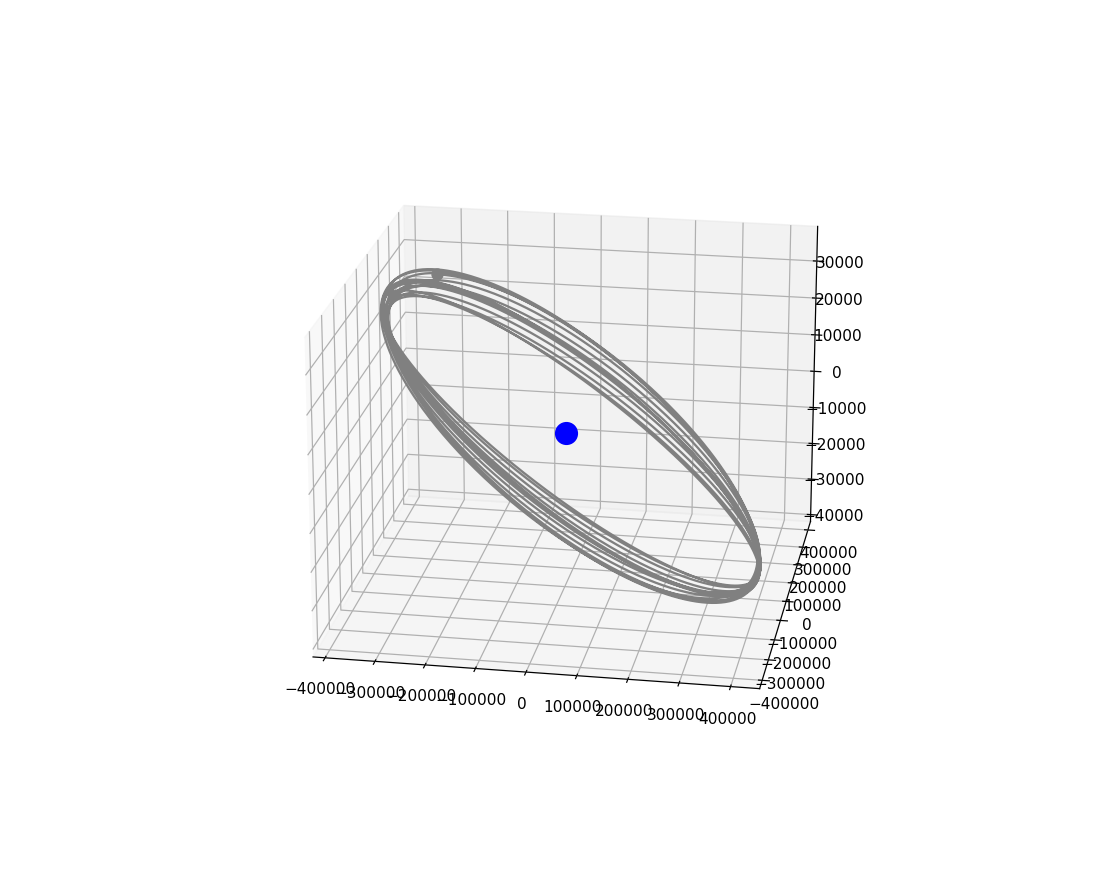

C:\Temp/ipykernel_11836/742091785.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [6]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
draw_planet_motion(earth_motion, True, 'blue', 200)
draw_planet_motion(moon_motion, True, 'grey', 50)

In [7]:
def vector_len(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

In [8]:
def forces_at_point(body_motion_list, body_mass_list, x, y, z, t):
    F_x = 0
    F_y = 0
    F_z = 0
    for i in range(len(body_motion_list)):
        t_int = int(t)
        F_x += G * body_mass_list[i] * (body_motion_list[i]['x'].values[t_int] - x) / (vector_len(body_motion_list[i]['x'].values[t_int], body_motion_list[i]['y'].values[t_int], body_motion_list[i]['z'].values[t_int], x, y, z)**3) 
        F_y += G * body_mass_list[i] * (body_motion_list[i]['y'].values[t_int] - y) / (vector_len(body_motion_list[i]['x'].values[t_int], body_motion_list[i]['y'].values[t_int], body_motion_list[i]['z'].values[t_int], x, y, z)**3) 
        F_z += G * body_mass_list[i] * (body_motion_list[i]['z'].values[t_int] - z) / (vector_len(body_motion_list[i]['x'].values[t_int], body_motion_list[i]['y'].values[t_int], body_motion_list[i]['z'].values[t_int], x, y, z)**3) 
    
    return [F_x, F_y, F_z]

In [9]:
def motion(t, state):
    x, y, z, vx, vy, vz, m = state
    t_int = int(t)
    F = forces_at_point([earth_motion, moon_motion], [M_earth, M_moon], x, y, z, t_int)
    
    dx = vx
    dy = vy
    dz = vz
    dvx = F[0] / m
    dvy = F[1] / m
    dvz = F[2] / m
    dm = a0 * delta / c0
    
    return [dx, dy, dz, dvx, dvy, dvz, dm]

In [18]:
G = (60**4)*6.67e-20

M_earth = 5.972e24
M_moon = 7.36e22

x0 = 200000
y0 = -90000
z0 = -30000
vx0 = 20
vy0 = -15
vz0 = 0
m0 = 10000
F0 = 21.6
a0 = F0 / m0
c0 = 20e3
delta = 0

initial_values = [x0, y0, z0, vx0, vy0, vz0, m0]  # Initial state of the system

<IPython.core.display.Javascript object>


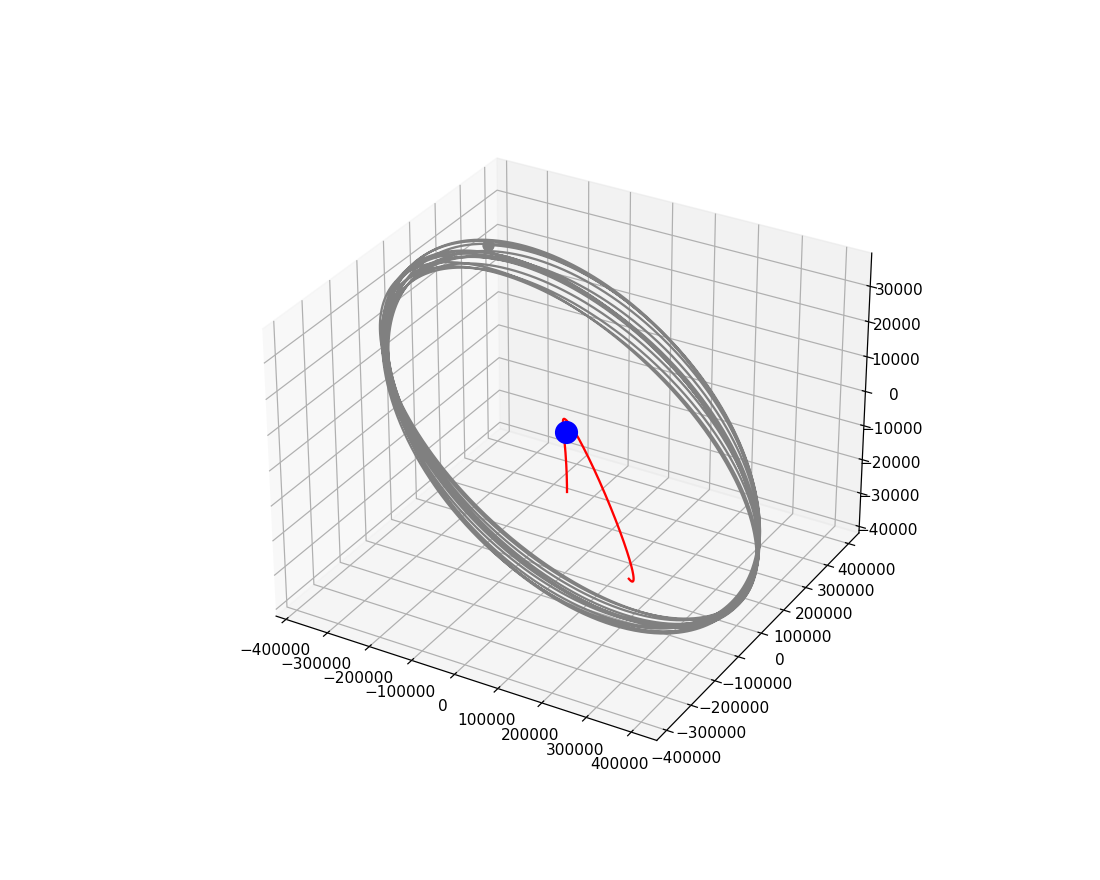

C:\Temp/ipykernel_11836/3430906829.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [26]:
t = np.arange(0, len(earth_motion)-1)
 
result_odeint = odeint(motion, initial_values, t, tfirst=True, mxstep = 0)
 
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.plot3D(result_odeint[:, 0], result_odeint[:, 1], result_odeint[:, 2], color = 'red')
draw_planet_motion(earth_motion, True, 'blue', 200)
draw_planet_motion(moon_motion, True, 'grey', 50)